In [238]:
%load_ext autoreload
%autoreload 2

from helpers import NormalizedEnv
from helpers import RandomAgent
import gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

from copy import deepcopy
from tqdm import tqdm
import importlib
from helpers import NormalizedEnv

from heuristicpolicy import HeuristicPendulumAgent
from qnetwork import QNetwork
from policynetwork import PolicyNetwork
from gaussian_action_noise import GaussianActionNoise
from ddpg_agent import DDPGAgent
from replaybuffer import ReplayBuffer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:


#Create random agent
# random_agent = RandomAgent(pendulum)
# heuristic_agent = HeuristicPendulumAgent(pendulum)

In [202]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [207]:
MAX_IT = 200
BUFFER_SIZE = 1e4

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
GAMMA = 0.99

In [239]:
torch.manual_seed(-1)

#Creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
#Wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)

noise = GaussianActionNoise()

network  = QNetwork().to(device) # critic
policy_network = PolicyNetwork().to(device) # actor

memory = ReplayBuffer(max_size=200)

In [242]:
agent = DDPGAgent(policy_network, noise)

In [243]:
#target_actor = HeuristicPendulumAgent(pendulum).to(device)

policy_optimizer  = optim.Adam(policy_network.parameters(),  lr=LEARNING_RATE)

MSE = nn.MSELoss()

In [236]:
def test_policy(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, network):

    targets = []
    q_state = []

    state = torch.FloatTensor(state_batch).to(device)
    action = torch.FloatTensor(np.array([action_batch])).to(device)
    reward = torch.FloatTensor(reward_batch).unsqueeze(1).to(device) #.unsqueeze(1)
    trunc = torch.Tensor(np.array([np.float32(trunc_batch)])).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state_batch).to(device)

    network_input_state = torch.cat((state, action.T),1)

    #compute loss for actor
    
    # N.B.: do not use the ”on-trajectory” actions, 
    # which were computed by a previous version of the policy network, 
    # you have to compute them with the current actor - DDPG is an off-policy algorithm
    network_input_state = torch.cat((state, policy_network(state)), 1)
    with torch.no_grad():
        policy_loss = -network(network_input_state)
        policy_loss = policy_loss.mean()
    
    
    return policy_loss

In [244]:
def learning_policy(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, network):

    targets = []
    q_state = []

    state = torch.FloatTensor(state_batch).to(device)
    action = torch.FloatTensor(np.array([action_batch])).to(device)
    reward = torch.FloatTensor(reward_batch).unsqueeze(1).to(device) #.unsqueeze(1)
    trunc = torch.Tensor(np.array([np.float32(trunc_batch)])).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state_batch).to(device)

    network_input_state = torch.cat((state, action.T),1)

    #compute loss for actor
    policy_optimizer.zero_grad()
    # N.B.: do not use the ”on-trajectory” actions, 
    # which were computed by a previous version of the policy network, 
    # you have to compute them with the current actor - DDPG is an off-policy algorithm
    network_input_state = torch.cat((state, policy_network(state)), 1)
    policy_loss = -network(network_input_state)
    policy_loss = policy_loss.mean()
    policy_loss.backward()
    policy_optimizer.step()
    
    return policy_loss

In [245]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
nr_of_samples = 128


In [248]:
current_state

array([-0.979431  ,  0.20177937, -0.55686694], dtype=float32)

In [255]:
action = agent.compute_action(state = current_state)
action

0.1416268

In [256]:
q_losses = []
for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        # how many iterations??
        action = agent.compute_action(state = current_state)
        #transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        
        # TODO: buffer_start = ??
        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            # TODO: sample random from 0 to 200??
            #indices = np.random.randint(0, 200, nr_of_samples)
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # 1-step TD-learning rule
            #TODO: the last update in each episode should use q = 0 !!
            policy_loss = learning_policy(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, network)
                       
        
        current_state = deepcopy(next_state)
        ep_reward += reward
    # plot_q.append([loss, episode])
    try:
        plot_reward.append([ep_reward, episode+1])
        plot_policy.append([policy_loss.data, episode+1])
        # plot_q.append([q_loss.data, episode+1])
        # q_losses.append(q_loss.item())

        if (episode % 100 == 0):
            print(policy_loss.item())
    except:
        continue


  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\User\anaconda3\envs\ann\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 1/1000 [00:00<04:23,  3.79it/s]

0.2474520206451416


 10%|█         | 101/1000 [01:26<11:26,  1.31it/s]

0.18772736191749573


 20%|██        | 201/1000 [03:03<11:23,  1.17it/s]

0.22876699268817902


 30%|███       | 301/1000 [04:30<10:53,  1.07it/s]

0.20285865664482117


 40%|████      | 401/1000 [06:12<09:42,  1.03it/s]

0.16994477808475494


 50%|█████     | 501/1000 [08:10<09:12,  1.11s/it]

0.2174103558063507


 60%|██████    | 601/1000 [09:44<06:04,  1.09it/s]

0.20744092762470245


 70%|███████   | 701/1000 [11:12<05:12,  1.04s/it]

0.22254659235477448


 80%|████████  | 801/1000 [12:47<02:22,  1.40it/s]

0.21148689091205597


 90%|█████████ | 901/1000 [14:12<01:15,  1.30it/s]

0.15639705955982208


100%|██████████| 1000/1000 [15:31<00:00,  1.07it/s]


In [188]:
# losses = []
# for episode in tqdm(range(NUM_EPISODES)):
#     current_state = deepcopy(pendulum.reset()[0])

#     ep_reward = 0.
#     ep_q_value = 0.
#     step=0

#     i = 0
#     # collect experience
#     for i in range(MAX_IT):
#         # how many iterations??
#         action = heuristic_agent.compute_action(state = current_state)
#         transformed_action = pendulum.action(action)
#         next_state, reward, term, trunc, info = pendulum.step(transformed_action)

#         memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        
#         # TODO: buffer_start = ??
#         if memory.count() > nr_of_samples:
#             # sample a batch of transitions from the replay buffer
#             # TODO: sample random from 0 to 200??
#             #indices = np.random.randint(0, 200, nr_of_samples)
#             state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

#             # 1-step TD-learning rule
#             #TODO: the last update in each episode should use q = 0 !!
#             q_loss = learning_policy(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, heuristic_agent, GAMMA, network, i)
                       
        
#         current_state = deepcopy(next_state)
#         ep_reward += reward
#     # plot_q.append([loss, episode])
#     try:
#         plot_q.append([q_loss.data, episode+1])
#         #q_losses.append(q_loss.item())

#         if (episode % 100 == 0):
#             print(q_loss.item())
#     except:
#         continue

    

 32%|███▏      | 317/1000 [01:39<02:45,  4.14it/s]

In [166]:
plt.print(losses)

2344.7842063289863

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def subplot(R, P, Q, S):
    r = list(zip(*R))
    p = list(zip(*P))
    q = list(zip(*Q))
    s = list(zip(*S))
    clear_output(wait=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    ax[0, 0].plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    ax[1, 0].plot(list(p[1]), list(p[0]), 'b') #row=1, col=0
    ax[0, 1].plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
    ax[1, 1].plot(list(s[1]), list(s[0]), 'k') #row=1, col=1
    ax[0, 0].title.set_text('Reward')
    ax[1, 0].title.set_text('Policy loss')
    ax[0, 1].title.set_text('Q loss')
    ax[1, 1].title.set_text('Max steps')
    plt.show()

Text(0.5, 1.0, 'Policy loss')

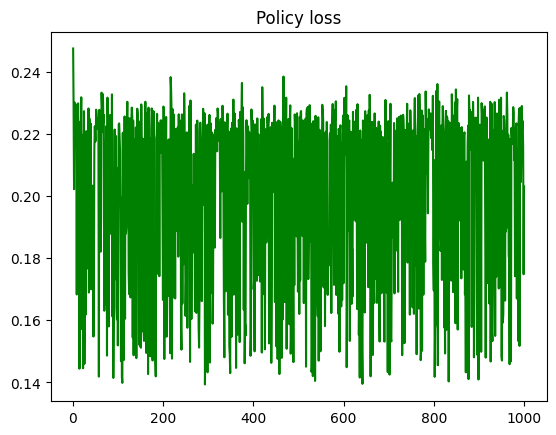

In [257]:
q = list(zip(*plot_policy))
plt.plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
plt.title('Policy loss')

In [ ]:
cumulative_reward = 0
for episode in tqdm(range(100)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        # how many iterations??
        action = agent.compute_action(state = current_state)
        # transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        
        # TODO: buffer_start = ??
        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            # TODO: sample random from 0 to 200??
            #indices = np.random.randint(0, 200, nr_of_samples)
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # 1-step TD-learning rule
            #TODO: the last update in each episode should use q = 0 !!
            policy_loss = test_policy(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, network)
                       
        
        current_state = deepcopy(next_state)
        cumulative_reward += reward
    # plot_q.append([loss, episode])
    try:
        # plot_reward.append([ep_reward, episode+1])
        # plot_policy.append([policy_loss.data, episode+1])
        # plot_q.append([q_loss.data, episode+1])
        # q_losses.append(q_loss.item())

        if (episode % 10 == 0):
            print(policy_loss.item())
    except:
        continue


In [ ]:
average_reward = cumulative_reward / 100

In [187]:
def run_test_episodes(env, policy, num_episodes):
    cumulative_reward = 0

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        done = False

        # TODO: how many iterations??
        while not done:
            action = policy.select_action(state)
            next_state, reward, done, _ = env.step(action)
            cumulative_reward += reward
            state = next_state

    average_reward = cumulative_reward / num_episodes
    return average_reward

[(array([0.97788984, 0.20912069, 0.18009238], dtype=float32),
  -1.0,
  -0.051627571543737774,
  array([0.9775334 , 0.2107805 , 0.03395293], dtype=float32),
  False),
 (array([ 0.95440036,  0.2985296 , -2.3184805 ], dtype=float32),
  1.0,
  -0.6334360689743704,
  array([ 0.9773568 ,  0.21159807, -1.7988373 ], dtype=float32),
  False)]